In [1]:
from init_plot import *

2024-09-15 15:57:14.951734: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[func help]----------------------------------------------------------------
> parameter
    p_root	[name] res_publish
        p_run, p_plot, p_res, p_cache, p_pdf
    p_df_varmap
    map_sp_reverse
    rng
[from func import * ]------------------------------------------------------
| p_root                  | display              | get_res_obs               |
| p_run                   | h5ad_to_mtx          | get_source_obs            |
| p_plot                  | load_adata           | get_matrix_max_prob_median|
| p_res                   | load_normalized_adata| get_matrix_count          |
| p_cache                 | pdf2_merge           | get_path_varmap           |
| p_pdf                   | show_umap            | get_res_stat              |
| p_data_process          | time_tag_detect      | find_path_from_para       |
| map_sp                  | time_tag_get         | func_help                 |
| map_sp_reverse          | time_tag_toggle      |                           |
| map_s

In [2]:
item = 'RA'
model = 'csMAHN'

df_para = pd.read_csv(p_cache.joinpath(
    'parameter_{}.csv'.format(item)
))
df_para['path_ref'] = df_para['path_ref'].apply(
    lambda x: p_cache.joinpath(x))
df_para['path_que'] = df_para['path_que'].apply(
    lambda x: p_cache.joinpath(x))

## plot_parameter

In [3]:
with Block("""
ppara_data
    res_RA
"""):
    df = get_test_result_df(p_res)
    df = df.query("tissue == 'RA'")
    df = df.map(lambda x:'CAME' if isinstance(x,str) and x == 'came' else x)
    df = ut.df.reindex_with_unique_col(df, 'model', drop=False)
    ppara_data['res_RA'] = df
    del df

with Block("ppara_adata"):
    for m, row in ppara_data['res_RA'].iterrows():
        adata = get_adata_umap(row, False)
        df_obs = adata.obs
        df_obs = df_obs.map(lambda x: 'DKK3+ sublining' 
                            if isinstance(x,str) and x == 'DKK3 + sublining' else x)
        
        df_obs['sp'] = df_obs['sp'].map(map_sp)
        # model_label ： ref 的 true_label 以及 que 的 pre label
        df_obs['model_label'] = ''
        df_obs['model_label'] = df_obs['model_label']\
            .mask(df_obs['dataset_type'] == 'ref', df_obs['true_label'])\
            .mask(df_obs['dataset_type'] == 'que', df_obs['pre_label'])
        adata.obs = df_obs
        ppara_adata['hm_{}'.format(m)] = adata
    del adata, df_obs, m, row
    
    # 构造 status
    data = ppara_adata['hm_csMAHN'].obs
    data['status'] = ''
    data['status'] = data['status'].mask(data['dataset_type'] == 'ref',
            data['preobs__batch'].str.extract('(\w{2})_',expand=False))\
        .mask(data['dataset_type'] == 'que',
            data['preobs__batch'].str.extract('^(.+);BRI',expand=False))\
        .str.replace(';',' ',regex=False)
    ppara_adata['hm_csMAHN'].obs = data
    
    
    for m in 'Seurat,SAMap,CAME'.split(','):
        ppara_adata['hm_{}'.format(m)].obs =  ppara_adata['hm_{}'.format(m)].obs.join(
        data.loc[:,['status']])
    del data,m

with Block("""
ppara_cmap
    cell_type
"""):
    # NPG-nrc 调整了顺序
    ppara_cmap['cell_type_all'] = {'CD34+ sublining': '#4DBBD5',
                 'HLA-DRA hi sublining': '#E64B35',
                 'DKK3+ sublining': '#00A087',
                 'lining': '#3C5488',
                 'sublining': '#F39B7F',
                 'intermediate': '#8491B4',
                 'perivascular': '#91D1C2'}
    ppara_cmap['cell_type'] = subset_dict(ppara_cmap['cell_type_all'],
        'CD34+ sublining,HLA-DRA hi sublining,DKK3+ sublining,lining'.split(','))

    ppara_cmap['m_status'] = pl.cmap.ggsci.get_cmap('NEJM',
        'Healthy WT,Healthy KO-Notch3,RA WT,RA KO-Notch3,RA WT ISO,RA WT anti-NRR3'.split(','))
    

with Block("""
ppara_data
    marker
    m_statue_ct
    enrich_df_F2
"""):

    with Block('marker'):
        ppara_data['marker_dotplot'] = {
            'ref': {
                'CD34+ sublining': 'CD34,CEBPD,C3'.split(','),
                'HLA-DRA hi sublining': 'IL6,STAT1,MMP2,MARCKSL1'.split(','),
                'DKK3+ sublining': 'DKK3,PRELP'.split(','),
                'lining': 'CD55,SOX5,SEMA3C,HBEGF'.split(',')},
            'que': {
                'CD34+ sublining': 'Cd34,Cebpd,C3,Il6'.split(','),
                'HLA-DRA hi sublining': 'Stat1,Mmp2,Marcksl1'.split(','),
                'DKK3+ sublining': 'Dkk3,Prelp'.split(','),
                'lining': 'Cd55,Sox5,Sema3c,Hbegf'.split(',')}
        }
    
    with Block('m_statue_ct'):
        for m in ppara_data['res_RA'].index:
            data = ppara_adata['hm_{}'.format(m)].obs
            data = ut.df.matrix_classify(data.query("dataset_type == 'que'"),'status','model_label')\
                .loc[ppara_cmap['m_status'].keys(),ppara_cmap['cell_type'].keys()]
            ppara_data['m_statue_ct_{}'.format(m)] = data
        del data

    with Block("enrich_df_F2"):
        with Block('EnrichmentAnalysis'):
            if not p_plot.joinpath(
                'data/EnrichmentAnalysis/RA_que_pre_HLA-DRA hi sublining').exists():
                sc.tl.rank_genes_groups(
                    adata_que,
                    groupby='pre_label',
                    method='wilcoxon')
                df_rank_gene = sc.get.rank_genes_groups_df(
                    adata_que, group=['HLA-DRA hi sublining'])\
                    .query("pvals_adj <0.01 & logfoldchanges > 1.5")
                print('[Enrich] {} genes'.format(df_rank_gene.shape[0]))
                EnrichmentAnalysis_run_with_r(
                    'RA_que_pre_HLA-DRA hi sublining',
                    'm2.cp',','.join(df_rank_gene['names']))
                del df_rank_gene
        df_enr_res = EnrichmentAnalysis_get_res_df()\
            .filter(regex='RA_que_pre', axis=0)
        data = EnrichmentAnalysis_get_adj(
            df_enr_res.loc['RA_que_pre_HLA-DRA hi sublining', :])
        data.shape
        data.index = data.index.to_series()\
            .apply(pl.tl_str_next_line, s_find='_', index=20)
        data = data.rename(columns={
            'RA_que_pre_HLA-DRA hi sublining': 'HLA-DRA hi sublining'})
        ppara_data['enrich_df_F2'] = data
        del df_enr_res,data


with Block('ppara_func vln_m_status'):
    def _func(adata,ax,key_group,gene,cmap):
        with Block('data df_stats'):
            data = ut.sc.get_obs_df(adata,[key_group,gene],layer=None).rename(columns={gene:'exp'})
            data = data.query("exp > 0")
            # ut.df.show(data)
            data_stats = multiple_test(data,key_group,'exp',
            ['Healthy WT,RA WT,RA WT ISO'.split(','),
             'Healthy KO-Notch3,RA KO-Notch3,RA WT anti-NRR3'.split(',')],
                          test_func=pl.stats.mannwhitneyu,fd_method='bh')
            data_stats['y'] = np.arange(data_stats.shape[0])*2
            data_stats['y'] = data_stats['y'].apply(lambda x:[x,x+1])
            data_stats['marker'] = pl.tl_get_significance_marker(data_stats['padj'])
            data_stats["color"] = (
                data_stats["mean_diff"]
                .apply(lambda x: "red" if x > 0 else "blue")
                .mask(data_stats["padj"] > 0.05, "grey")
            )
        with Block('plot'):
            for i,(g,df_plot) in enumerate(ut.df.group_yield(data,key_group,'exp',cmap.keys(),return_group=True)):
                # ut.df.show(df_plot)
                dict_violin = dict(color="#FFFFFF", linecolor=cmap[g], linewidth=0.5)
                dict_box = dict(scatter_size=5, scatter_key_center="median",
                            scatter_marker=".", scatter_color="grey", lines_color=cmap[g])
                pl.violinplot(df_plot,ax,positions=i,dict_violin =dict_violin,dict_box = dict_box,
                              vertical=False)
            ax.set_yticks(np.arange(len(cmap.keys())),cmap.keys())
            ax.set_title(gene)
            pl.tl_expand_ax(ax,.07,'x')
            data_stats.apply(lambda row :pl.tl_stats_bar(ax,row['y'],text=row['marker'],vertical=True,
                fontdict=dict(color = row['color'],rotation=-90)) ,axis=1)
    ppara_func['vln_m_status'] = _func
    del _func


[extract]
^(?P<tissue>.+)_(?P<sp_ref>.+)-corss-(?P<sp_que>.+);(?P<model>came|csMAHN|Seurat|SAMap);(?P<name_ref>[\w-]+)-map-(?P<name_que>[[\w-]+);?(?P<resdir_tag>.+)?$


/public/workspace/licanchengup/apps/miniconda3/envs/publish/lib/python3.9/site-packages/pandas/core/strings/accessor.py:2738: FutureWarning: Possible nested set at position 127
  regex = re.compile(pat, flags=flags)


# plot

[out][plot] RA_csMAHN.png 
	in /public/workspace/licanchengup/link/res_publish/plot/pdf
[out][plot] RA_csMAHN.svg 
	in /public/workspace/licanchengup/link/res_publish/plot/pdf
***************************************************************************
(A) The UMAP plot of embeddings outputted by RA patients and mouse fibroblasts, applied
with csMAHN, RA patient true label (left panel), mouse predict label (left
panel). (B,C) Gene expression of marker in RA patients and mouse fibroblasts.
(D) The distribution of HLA-DRA hi sublining fibroblasts (right panel) with mouse
status. 
***************************************************************************


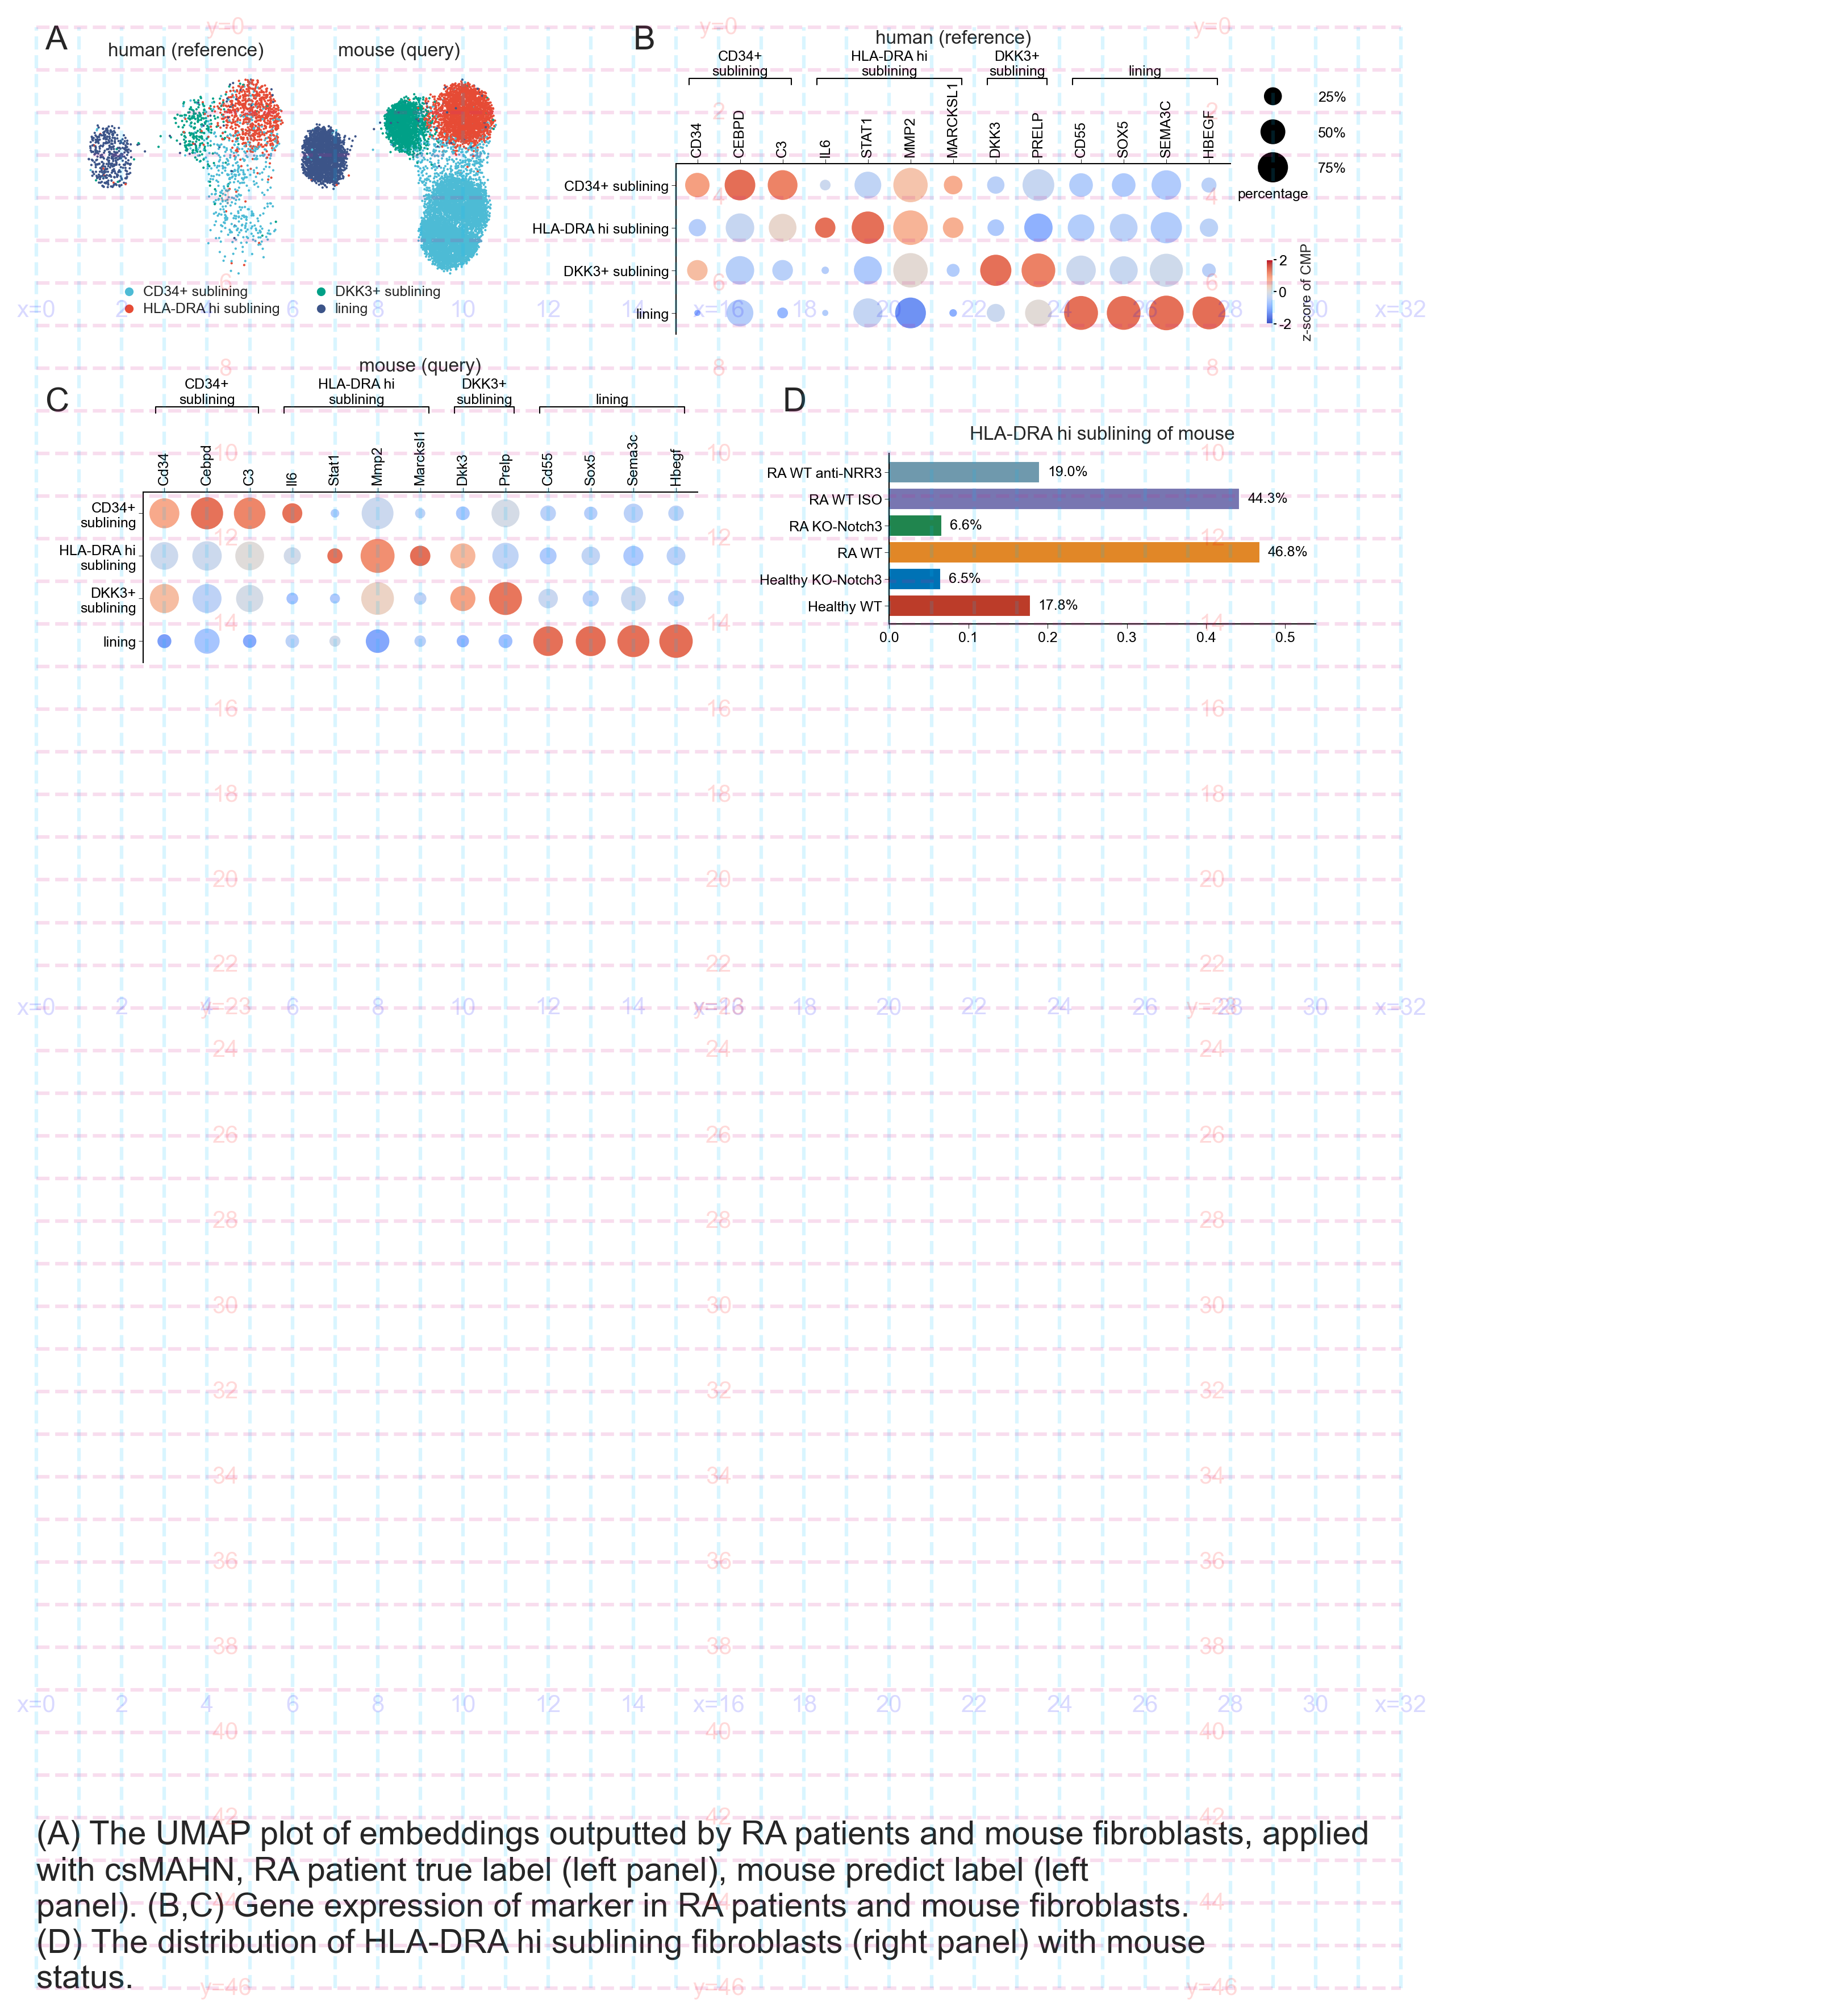

In [4]:
plt.close("all")
a4p = pl.figure.A4Page()
y = 1
with Block("UMAP", context=dict(x=1, y=y, size=1)) as context:
    adata = ppara_adata['hm_csMAHN']
    adata = ut.sc.load_obsm_UMAP(adata,'UMAP1,UMAP2'.split(','))
    cmap = ppara_cmap['cell_type']
    ppara = dict(cmap=cmap, key='model_label', size=context.size)

    ax = a4p.add_ax(context.x, context.y, 5, 5)
    ut.sc.pl.umap(ut.sc.subset_adata(adata, 'dataset_type', 'ref'), ax=ax, **ppara)
    ax.set_title('human (reference)')
    ax = a4p.add_ax(context.x+5, context.y, 5, 5)
    ut.sc.pl.umap(ut.sc.subset_adata(adata, 'dataset_type', 'que'), ax=ax, **ppara)
    ax.set_title('mouse (query)')

    a4p.area_update(context.x+1, context.y+5, 1, 2, 1, .8, gap_width=3.5)
    # a4p.area_show()
    for ax, keys in zip(a4p.area_yield_ax(),
                        np.array_split(list(cmap.keys()), 2)):
        pl.cmap.show(subset_dict(cmap, keys), ax=ax)
    del adata, ppara, ax, keys

with Block('marker', context=dict(x=15, y=y, item='csMAHN', size=1)) as context:
    row = ppara_data['res_RA'].loc[context.item, :]
    cmap = ppara_cmap['cell_type']
    adata = ppara_adata['hm_{}'.format(context.item)]
    marker_dict = ppara_data['marker_dotplot']
    adata_ref = load_normalized_adata(find_path_from_para(df_para,row['name_ref']),
                                     adata.obs)
    adata_que = load_normalized_adata(find_path_from_para(df_para,row['name_que']),
                                     adata.obs)
    kw_cbar=dict(format='{x:.0f}', aspect=10, label='z-score of CMP')
    ppara = dict(key_group='model_label',transpose = True,
                 kw_bubble=dict(vmax=2.5, vmin=-2.5, cmap='coolwarm'))
    with Block('ref'):
        ppara.update(adata=adata_ref,
                     genes=np.concatenate(list(marker_dict['ref'].values())),
                     order=list(marker_dict['ref'].keys()))
        with Block('bar'):
            ax = a4p.add_ax(context.x,context.y,len(ppara['genes']),1,rc=pl.rc_blank)
            ax.set_xlim(0,len(ppara['genes'])),ax.set_ylim(0,1)
            pl.tl_stats_bar(ax,[0+.3,3-.3],text='CD34+\nsublining',bottom=.65,top=.8)
            pl.tl_stats_bar(ax,[3+.3,7-.3],text='HLA-DRA hi\nsublining',bottom=.65,top=.8)
            pl.tl_stats_bar(ax,[7+.3,9-.3],text='DKK3+\nsublining',bottom=.65,top=.8)
            pl.tl_stats_bar(ax,[9+.3,13-.3],text='lining',bottom=.65,top=.8)
            ax.set_title('human (reference)',y=1.3)
        context.y += 2.2
        ax = a4p.add_ax(context.x,context.y,len(ppara['genes']),len(ppara['order']),rc=pl.rc_frame_lt)
        cbar = dotplot_marker(ax=ax, **ppara)
    with Block('legend'):
        ax = a4p.add_ax(context.x+13,context.y-2, 2, 2.5, rc=update_dict(pl.rc_blank, {
            'ytick.labelright': True, 'xtick.labelbottom': True}))
        dotplot_marker_legend(ax,draw_cbar=False)

        ax = a4p.add_ax(context.x+13,context.y+2,1,2,rc=pl.rc_blank)
        cbar = a4p.fig.colorbar(cbar,ax=ax,**kw_cbar)
        cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    context.y += 5.5
    context.x = 2.5
    with Block('que'):
        ppara.update(adata=adata_que,
                     genes=np.concatenate(list(marker_dict['que'].values())),
                     order=list(marker_dict['que'].keys()))
        with Block('bar'):
            ax = a4p.add_ax(context.x,context.y,len(ppara['genes']),1,rc=pl.rc_blank)
            ax.set_xlim(0,len(ppara['genes'])),ax.set_ylim(0,1)
            pl.tl_stats_bar(ax,[0+.3,3-.3],text='CD34+\nsublining',bottom=.65,top=.8)
            pl.tl_stats_bar(ax,[3+.3,7-.3],text='HLA-DRA hi\nsublining',bottom=.65,top=.8)
            pl.tl_stats_bar(ax,[7+.3,9-.3],text='DKK3+\nsublining',bottom=.65,top=.8)
            pl.tl_stats_bar(ax,[9+.3,13-.3],text='lining',bottom=.65,top=.8)
            ax.set_title('mouse (query)',y=1.3)
        context.y += 2.2
        ax = a4p.add_ax(context.x,context.y,len(ppara['genes']),len(ppara['order']),rc=pl.rc_frame_lt)
        cbar = dotplot_marker(ax=ax, **ppara)
        ax.set_yticklabels([i.get_text().replace(' sublining','\nsublining') for i in ax.get_yticklabels()])

    del row,cmap,adata,marker_dict,adata_ref,adata_que,kw_cbar,ppara

y += 9
with Block('hbar',context=dict(ct= 'HLA-DRA hi sublining',x=20,y=y)) as context:
    with Block('data df_plot'):
        df_plot = ppara_data['m_statue_ct_csMAHN'].copy()
        data = df_plot.copy().rename(columns = {context.ct:'count'}).loc[:,['count']]
        data['total'] = df_plot.sum(axis=1)
        data['ratio'] = data.eval('count/total')
        # data['text'] = ut.df.apply_merge_field(data,'{count:.0f}/{total:.0f}')
        data['text'] = data['ratio'].apply(lambda x:'{:.1f}%'.format(x*100))
        data['y'] = np.arange(data.shape[0])
        df_plot = data.loc[:,['ratio']].transpose()

    ax = a4p.add_ax(context.x,context.y,10,4,rc=pl.rc_frame)
    cmap = ppara_cmap['m_status']
    para = dict(gap_between_group=2,width_one_bar=1,
               width_ratio=.8, to_horizontal=True)
    for i, (k) in enumerate(df_plot.columns):
        pl.bar(ax, df_plot, key_height=k,cmap=cmap,bottom=0,
               group_counts=df_plot.shape[0],ngroup=i,**para)
    ax.set_yticks(np.arange(len(data.index)),data.index)
    for i,row in data.iterrows():
        ax.text(row['ratio']+.01,row['y'],row['text'],pl.tl_fontdict('lc'))
    ax.set_xlim(0,data['ratio'].max()+.07)
    ax.set_title('{} of mouse'.format(context.ct))

    del df_plot,data,ax,cmap,para

with Block('text'):
    for text, (x, y) in zip(
        [chr(65+i) for i in range(26)],np.array([
          [.2,.5],[14,.5],[.2,9],[17.5,9],# ABCD
        ])):
        a4p.add_text_with_ax(a4p.add_ax(x, y), text)
    del text, x, y

pl.tl_savefig(a4p.fig, '{}_{}.png'.format(item, model), p_pdf)
pl.tl_savefig(a4p.fig, '{}_{}.svg'.format(item, model), p_pdf)

with Block('note'):
    text = "\
(A) The UMAP plot of embeddings outputted by RA patients and mouse fibroblasts, applied with csMAHN, RA patient true label (left panel), mouse predict label (left panel). \
(B,C) Gene expression of marker in RA patients and mouse fibroblasts. \
(D) The distribution of HLA-DRA hi sublining fibroblasts (right panel) with mouse status. \
"
    text = pl.tl_str_next_line(text,80,' ')
    a4p.add_text_with_ax(a4p.add_ax(0, 45, 42),text, 0, 0)
    print("{1}\n{0}\n{1}".format(text, '*'*75))
    del text
a4p.save_as_pdf(p_pdf.joinpath('{}_{}.pdf'.format(item, model)))
a4p.add_grid()
a4p.fig

# supp

[out][plot] RA_csMAHN_supp.png 
	in /public/workspace/licanchengup/link/res_publish/plot/pdf
[out][plot] RA_csMAHN_supp.svg 
	in /public/workspace/licanchengup/link/res_publish/plot/pdf
***************************************************************************
(A) Original UMAP plot of human and mosue fibroblast. (B) Dot plot showing posterior
probability of the mouse fibroblast integrating human and mouse lung cancer
immune cells using csMAHN, The size of the dots corresponds to the proportion of
each original label that is assigned to each csMAHN label. (C) Enrich analysis
of mouse HLA-DRA hi sublining. (D) Gene expression of cytokine in each mouse status.
(E) Gene expression of MHC-calss II in each mouse status. (F) Gene expression
of MMPs in each mouse status.
***************************************************************************


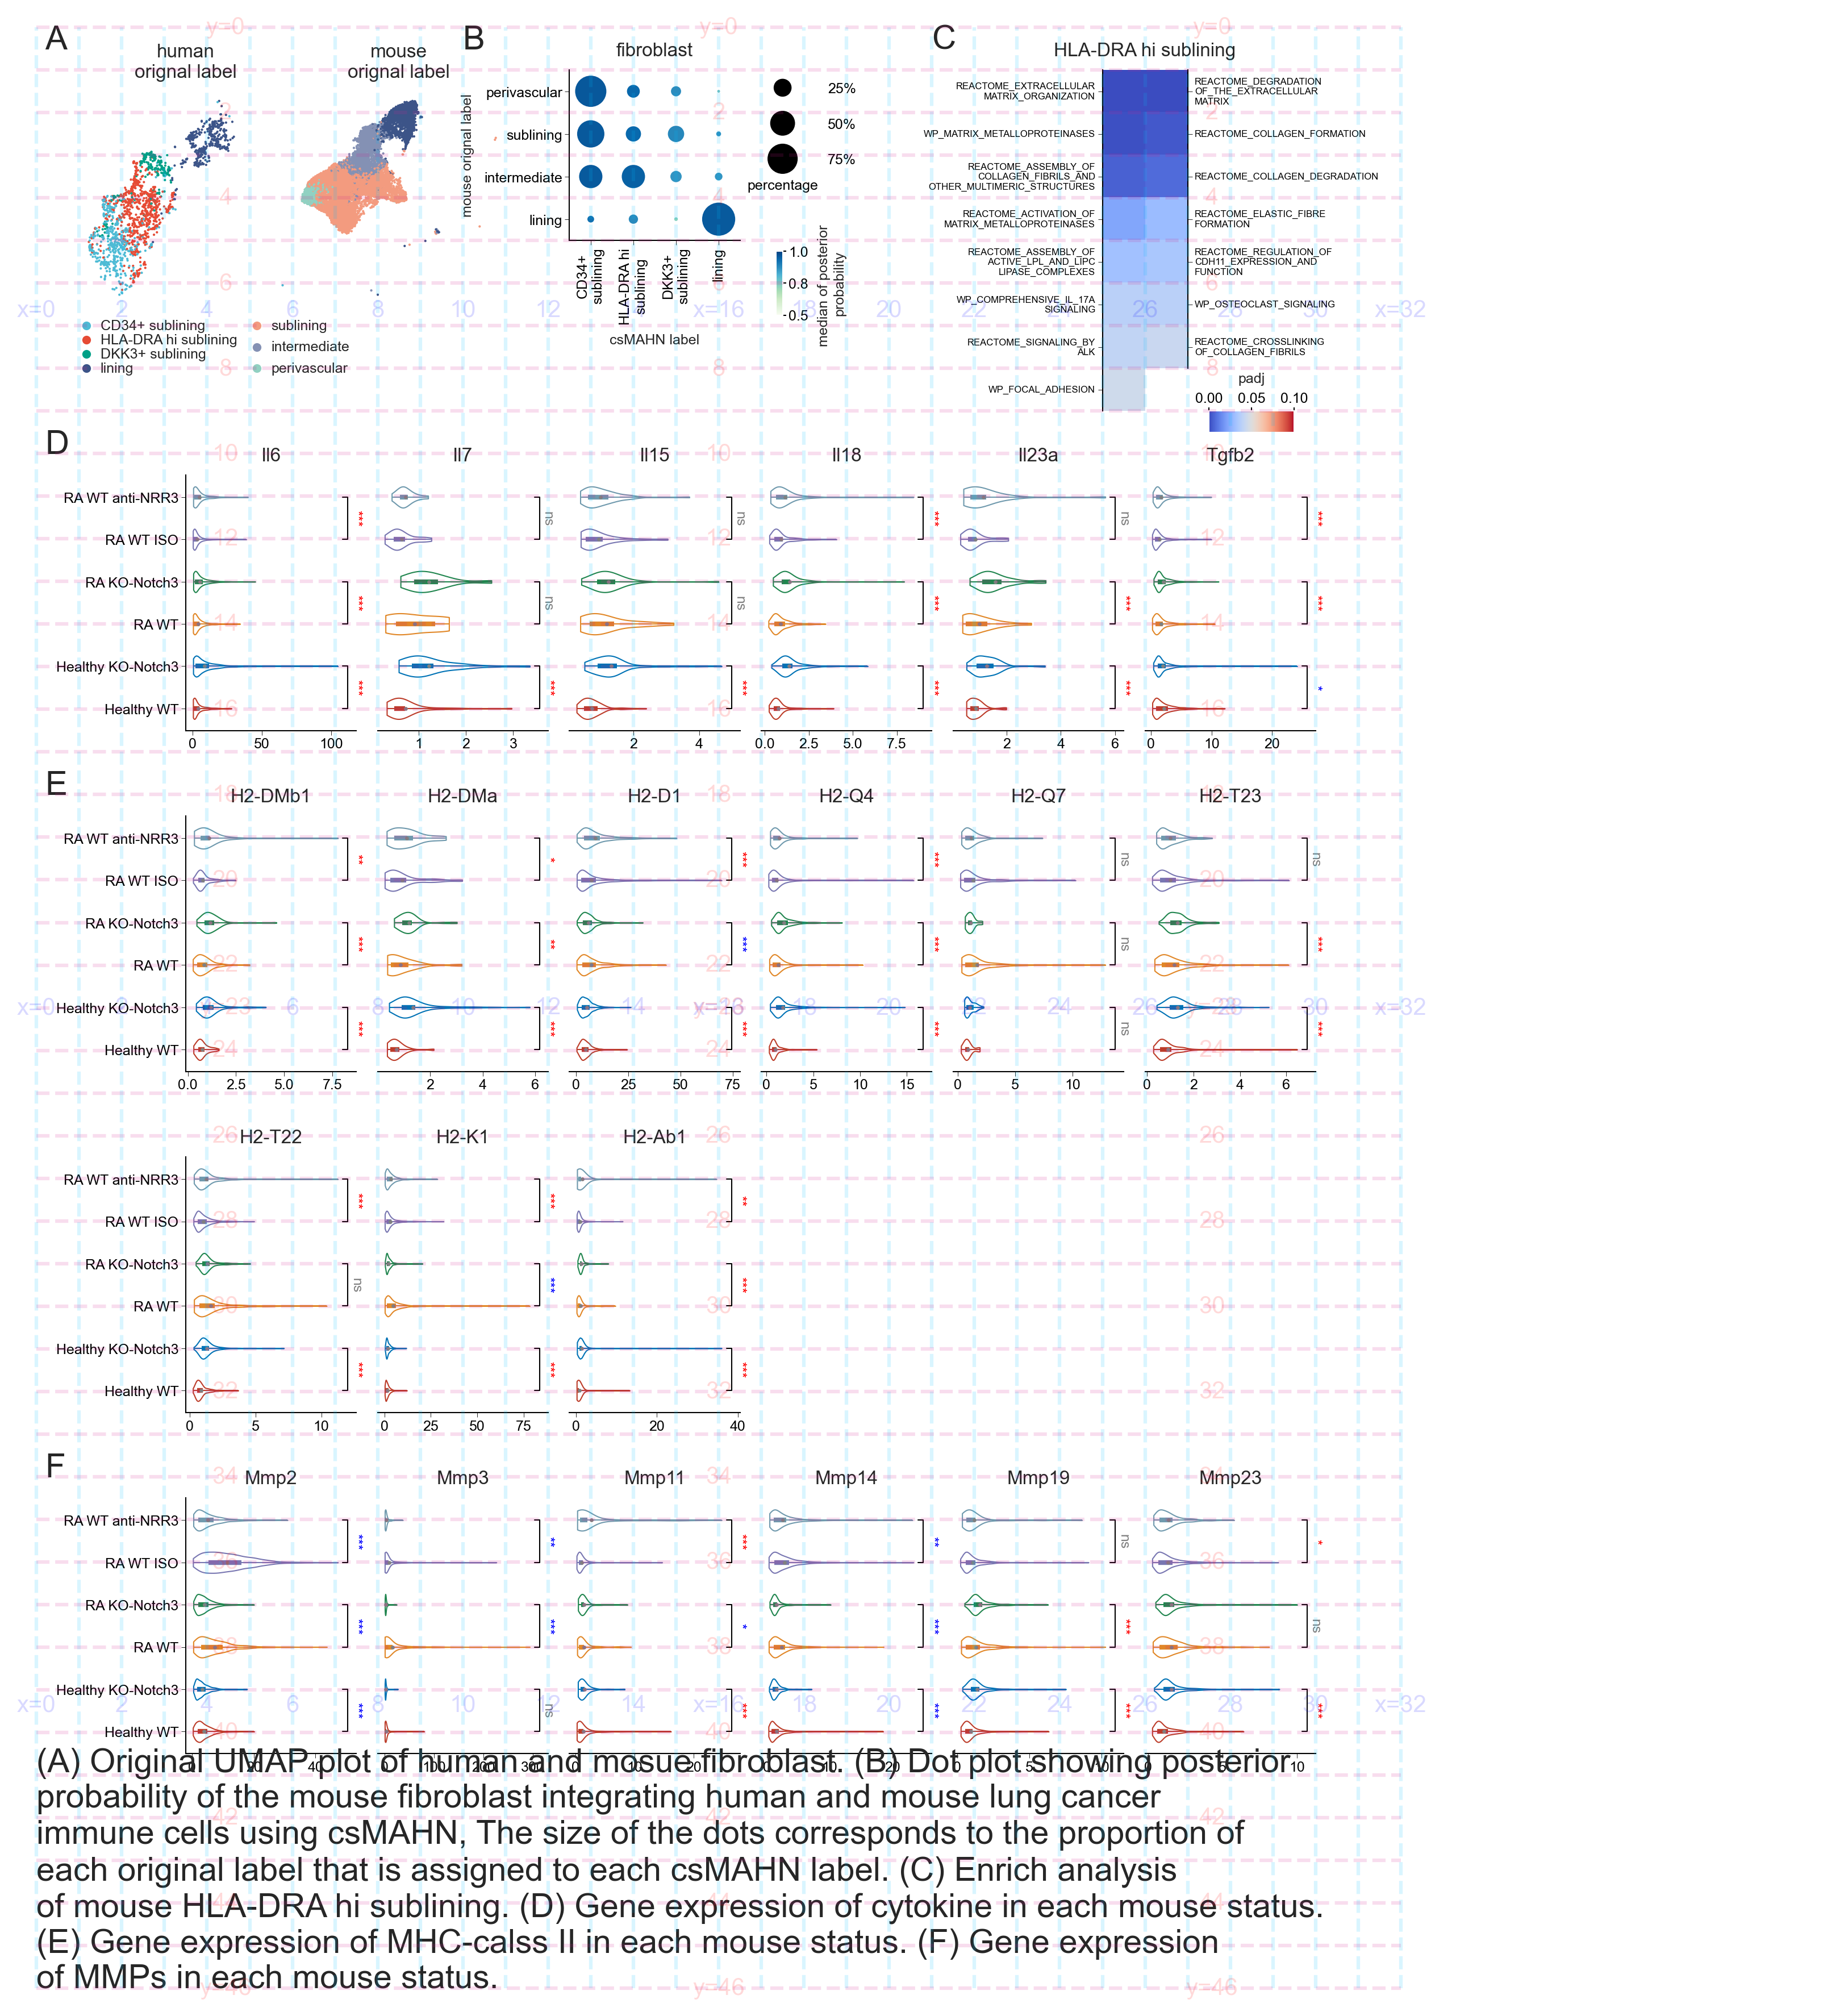

In [5]:
plt.close("all")
a4p = pl.figure.A4Page()
y = 1.5
with Block("UMAP orignal label",context=dict(x=1,y=y,size = 1)) as context:

    adata = ppara_adata['hm_csMAHN']
    adata.obs['preobs_UMAP1'] = adata.obs['preobs_UMAP1'].mask(adata.obs['dataset_type']=='ref',adata.obs['preobs_x'])
    adata.obs['preobs_UMAP2'] = adata.obs['preobs_UMAP2'].mask(adata.obs['dataset_type']=='ref',adata.obs['preobs_y'])

    adata = ut.sc.load_obsm_UMAP(adata,'preobs_UMAP1,preobs_UMAP2'.split(','))
    cmap = ppara_cmap['cell_type_all']
    ppara = dict(key='true_label',cmap=cmap,size=context.size)

    ax = a4p.add_ax(context.x,context.y,5,5)
    ut.sc.pl.umap(ut.sc.subset_adata(adata,'dataset_type','ref'),ax=ax,**ppara)
    ax.set_title('human\norignal label')
    
    ax = a4p.add_ax(context.x+5,context.y,5,5)
    ut.sc.pl.umap(ut.sc.subset_adata(adata,'dataset_type','que'),ax=ax,**ppara)
    ax.set_title('mouse\norignal label')
    
    a4p.area_update(context.x,context.y+5,1,2,1,2,gap_width=3)
    # a4p.area_show()
    for ax,keys in zip(
        a4p.area_yield_ax(rc=pl.rc_blank),
        np.array_split(list(cmap.keys()),2)
    ):
        pl.cmap.show(subset_dict(cmap,keys),ax=ax)
    # ax = a4p.add_ax(context.x,context.y,1,4)
    # pl.cmap.show(cmap,ax=ax)
    
    del adata,cmap,ppara,ax,keys

with Block('posterior probability', context=dict(x=12.5, y=y-.5,
        cmap='GnBu',item='csMAHN')) as context:
    ppara = dict(
        data=ppara_adata['hm_{}'.format(context.item)].obs.query("dataset_type == 'que' "),
        kw_bubble=dict(vmax=1, vmin=.5, cmap=context.cmap),
        order_col=list(ppara_cmap['cell_type'].keys()),
        order_row= 'perivascular,sublining,intermediate,lining'.split(',')
    )
    kw_cbar=dict(format='{x:.1f}', aspect=10,label='median of posterior \nprobability')
    ax = a4p.add_ax(context.x, context.y, len(ppara['order_col']),
                    len(ppara['order_row']),rc=pl.rc_frame)
    ax.set_title('fibroblast')
    cbar = dotplot_max_prob_median(ax=ax, **ppara)
    ax.set_xticklabels([i.get_text().replace(' sublining','\nsublining') for i in ax.get_xticklabels()])
    ax.set_ylabel('mouse orignal label')
    ax.set_xlabel('csMAHN label')
    

    ax = a4p.add_ax(context.x+4,context.y, 2, 2.5, rc=update_dict(pl.rc_blank,
            {'ytick.labelright': True, 'xtick.labelbottom': True}))
    dotplot_marker_legend(ax,draw_cbar=False)
    ax = a4p.add_ax(context.x+4, context.y+4, 1, 2, rc=pl.rc_blank)
    cbar = a4p.fig.colorbar(cbar, ax=ax, **kw_cbar)
    cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    del ppara, ax, cbar,kw_cbar

with Block('enrich',context=dict(x=25,y=y-.5)) as context:
    data = ppara_data['enrich_df_F2']
    df_plot = data.iloc[::2,:].transpose()
    
    ppara = dict(vmax=.1,vmin=0,marker='s',cmap='coolwarm',
                fontdict_ytick = pl.tl_fontdict('rc',fontsize=4))
    kw_cbar=dict(format='{x:.2f}', aspect=4,shrink=1, fraction=1,
                 label='padj',orientation='horizontal',location='top'
                )
    # left
    df_size = pd.DataFrame(np.ones(df_plot.shape),index=df_plot.index,
                 columns=df_plot.columns)
    ax = a4p.add_ax(context.x,context.y,1,df_size.shape[1],
                    rc=pl.tl_rc(pl.rc_frame,pl.rc_tl_off_x))
    cbar = pl.bubble(df_size*320,ax,df_plot,**ppara)
    
    # right
    ppara.update(fontdict_ytick = pl.tl_fontdict('lc',fontsize=4))
    df_plot = data.iloc[1::2,:].transpose()
    df_size = pd.DataFrame(np.ones(df_plot.shape),index=df_plot.index,
                 columns=df_plot.columns)
    ax = a4p.add_ax(context.x+1,context.y,1,df_size.shape[1],
                    rc=pl.tl_rc(pl.rc_frame,pl.rc_tl_off_x,
                                pl.rc_tl_off_y,pl.rc_tl_yr))
    cbar = pl.bubble(df_size*320,ax,df_plot,**ppara)
    # cbar
    ax = a4p.add_ax(context.x+2.5,context.y+7.5,2,1,rc=pl.rc_blank)
    cbar = a4p.fig.colorbar(cbar,ax=ax,**kw_cbar)
    cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    # title
    a4p.add_ax(context.x,context.y,2,1,rc=pl.rc_blank)\
        .set_title('HLA-DRA hi sublining')
    del data,df_plot,ppara,kw_cbar,df_size,ax,cbar
y += 9
with Block("vln_m_status cytokine",context=dict(x=3.5,y=y,item = 'csMAHN')) as context:
    genes = 'Il6,Il7,Il15,Il18,Il23a,Tgfb2'.split(',')
    row = ppara_data['res_RA'].loc[context.item,:]
    ppara = dict(
        adata = load_normalized_adata(find_path_from_para(df_para,row['name_que']),
                                      ppara_adata['hm_{}'.format(context.item)].obs),
        cmap = ppara_cmap['m_status'],
        key_group = 'status'
    )
    a4p.area_update(context.x,context.y,1,len(genes),4,6,gap_width=.5)
    for i,gene in enumerate(genes):
        ax = a4p.area_get_ax(i,rc = pl.tl_rc(pl.rc_frame,pl.rc_tl_off_y) if i else pl.rc_frame)
        ppara_func['vln_m_status'](ax=ax,gene=gene,**ppara)
    del genes,row,ppara,i,gene,ax
y += 8
with Block("vln_m_status MHC-class2",context=dict(x=3.5,y=y,item = 'csMAHN')) as context:
    genes = 'H2-DMb1,H2-DMa,H2-D1,H2-Q4,H2-Q7,H2-T23'.split(',')
    row = ppara_data['res_RA'].loc[context.item,:]
    ppara = dict(
        adata = load_normalized_adata(find_path_from_para(df_para,row['name_que']),
                                      ppara_adata['hm_{}'.format(context.item)].obs),
        cmap = ppara_cmap['m_status'],
        key_group = 'status'
    )
    a4p.area_update(context.x,context.y,1,len(genes),4,6,gap_width=.5)
    for i,gene in enumerate(genes):
        ax = a4p.area_get_ax(i,rc = pl.tl_rc(pl.rc_frame,pl.rc_tl_off_y) if i else pl.rc_frame)
        ppara_func['vln_m_status'](ax=ax,gene=gene,**ppara)

    context.y += 8
    genes = 'H2-T22,H2-K1,H2-Ab1'.split(',')
    a4p.area_update(context.x,context.y,1,len(genes),4,6,gap_width=.5)
    for i,gene in enumerate(genes):
        ax = a4p.area_get_ax(i,rc = pl.tl_rc(pl.rc_frame,pl.rc_tl_off_y) if i else pl.rc_frame)
        ppara_func['vln_m_status'](ax=ax,gene=gene,**ppara)
    del genes,row,ppara,i,gene,ax
y += 8*2
with Block("vln_m_status MMPs",context=dict(x=3.5,y=y,item = 'csMAHN')) as context:
    genes = 'Mmp2,Mmp3,Mmp11,Mmp14,Mmp19,Mmp23'.split(',')
    row = ppara_data['res_RA'].loc[context.item,:]
    ppara = dict(
        adata = load_normalized_adata(find_path_from_para(df_para,row['name_que']),
                                      ppara_adata['hm_{}'.format(context.item)].obs),
        cmap = ppara_cmap['m_status'],
        key_group = 'status'
    )
    a4p.area_update(context.x,context.y,1,len(genes),4,6,gap_width=.5)
    for i,gene in enumerate(genes):
        ax = a4p.area_get_ax(i,rc = pl.tl_rc(pl.rc_frame,pl.rc_tl_off_y) if i else pl.rc_frame)
        ppara_func['vln_m_status'](ax=ax,gene=gene,**ppara)
    del genes,row,ppara,i,gene,ax

with Block('text'):
    for text, (x, y) in zip(
        [chr(65+i) for i in range(26)],np.array([
          [.2,.5],[10,.5],[21,.5],[.2,10],# ABCD
          [.2,18],[.2,34],# EF
        ])):
        a4p.add_text_with_ax(a4p.add_ax(x, y), text)
    del text, x, y

pl.tl_savefig(a4p.fig, '{}_{}_supp.png'.format(item, model), p_pdf)
pl.tl_savefig(a4p.fig, '{}_{}_supp.svg'.format(item, model), p_pdf)

with Block('note'):
    text = "(A) Original UMAP plot of human and mosue fibroblast. \
(B) Dot plot showing posterior probability of the mouse fibroblast integrating human and mouse lung cancer immune cells using csMAHN, \
The size of the dots corresponds to the proportion of each original label that is assigned to each csMAHN label. \
(C) Enrich analysis of mouse HLA-DRA hi sublining. \
(D) Gene expression of cytokine in each mouse status. \
(E) Gene expression of MHC-calss II in each mouse status. \
(F) Gene expression of MMPs in each mouse status."
    text = pl.tl_str_next_line(text,80,' ')
    a4p.add_text_with_ax(a4p.add_ax(0, 45, 42),text, 0, 0)
    print("{1}\n{0}\n{1}".format(text, '*'*75))
    del text

a4p.save_as_pdf(p_pdf.joinpath('{}_{}_supp.pdf'.format(item, model)))

a4p.add_grid()
a4p.fig

# draft

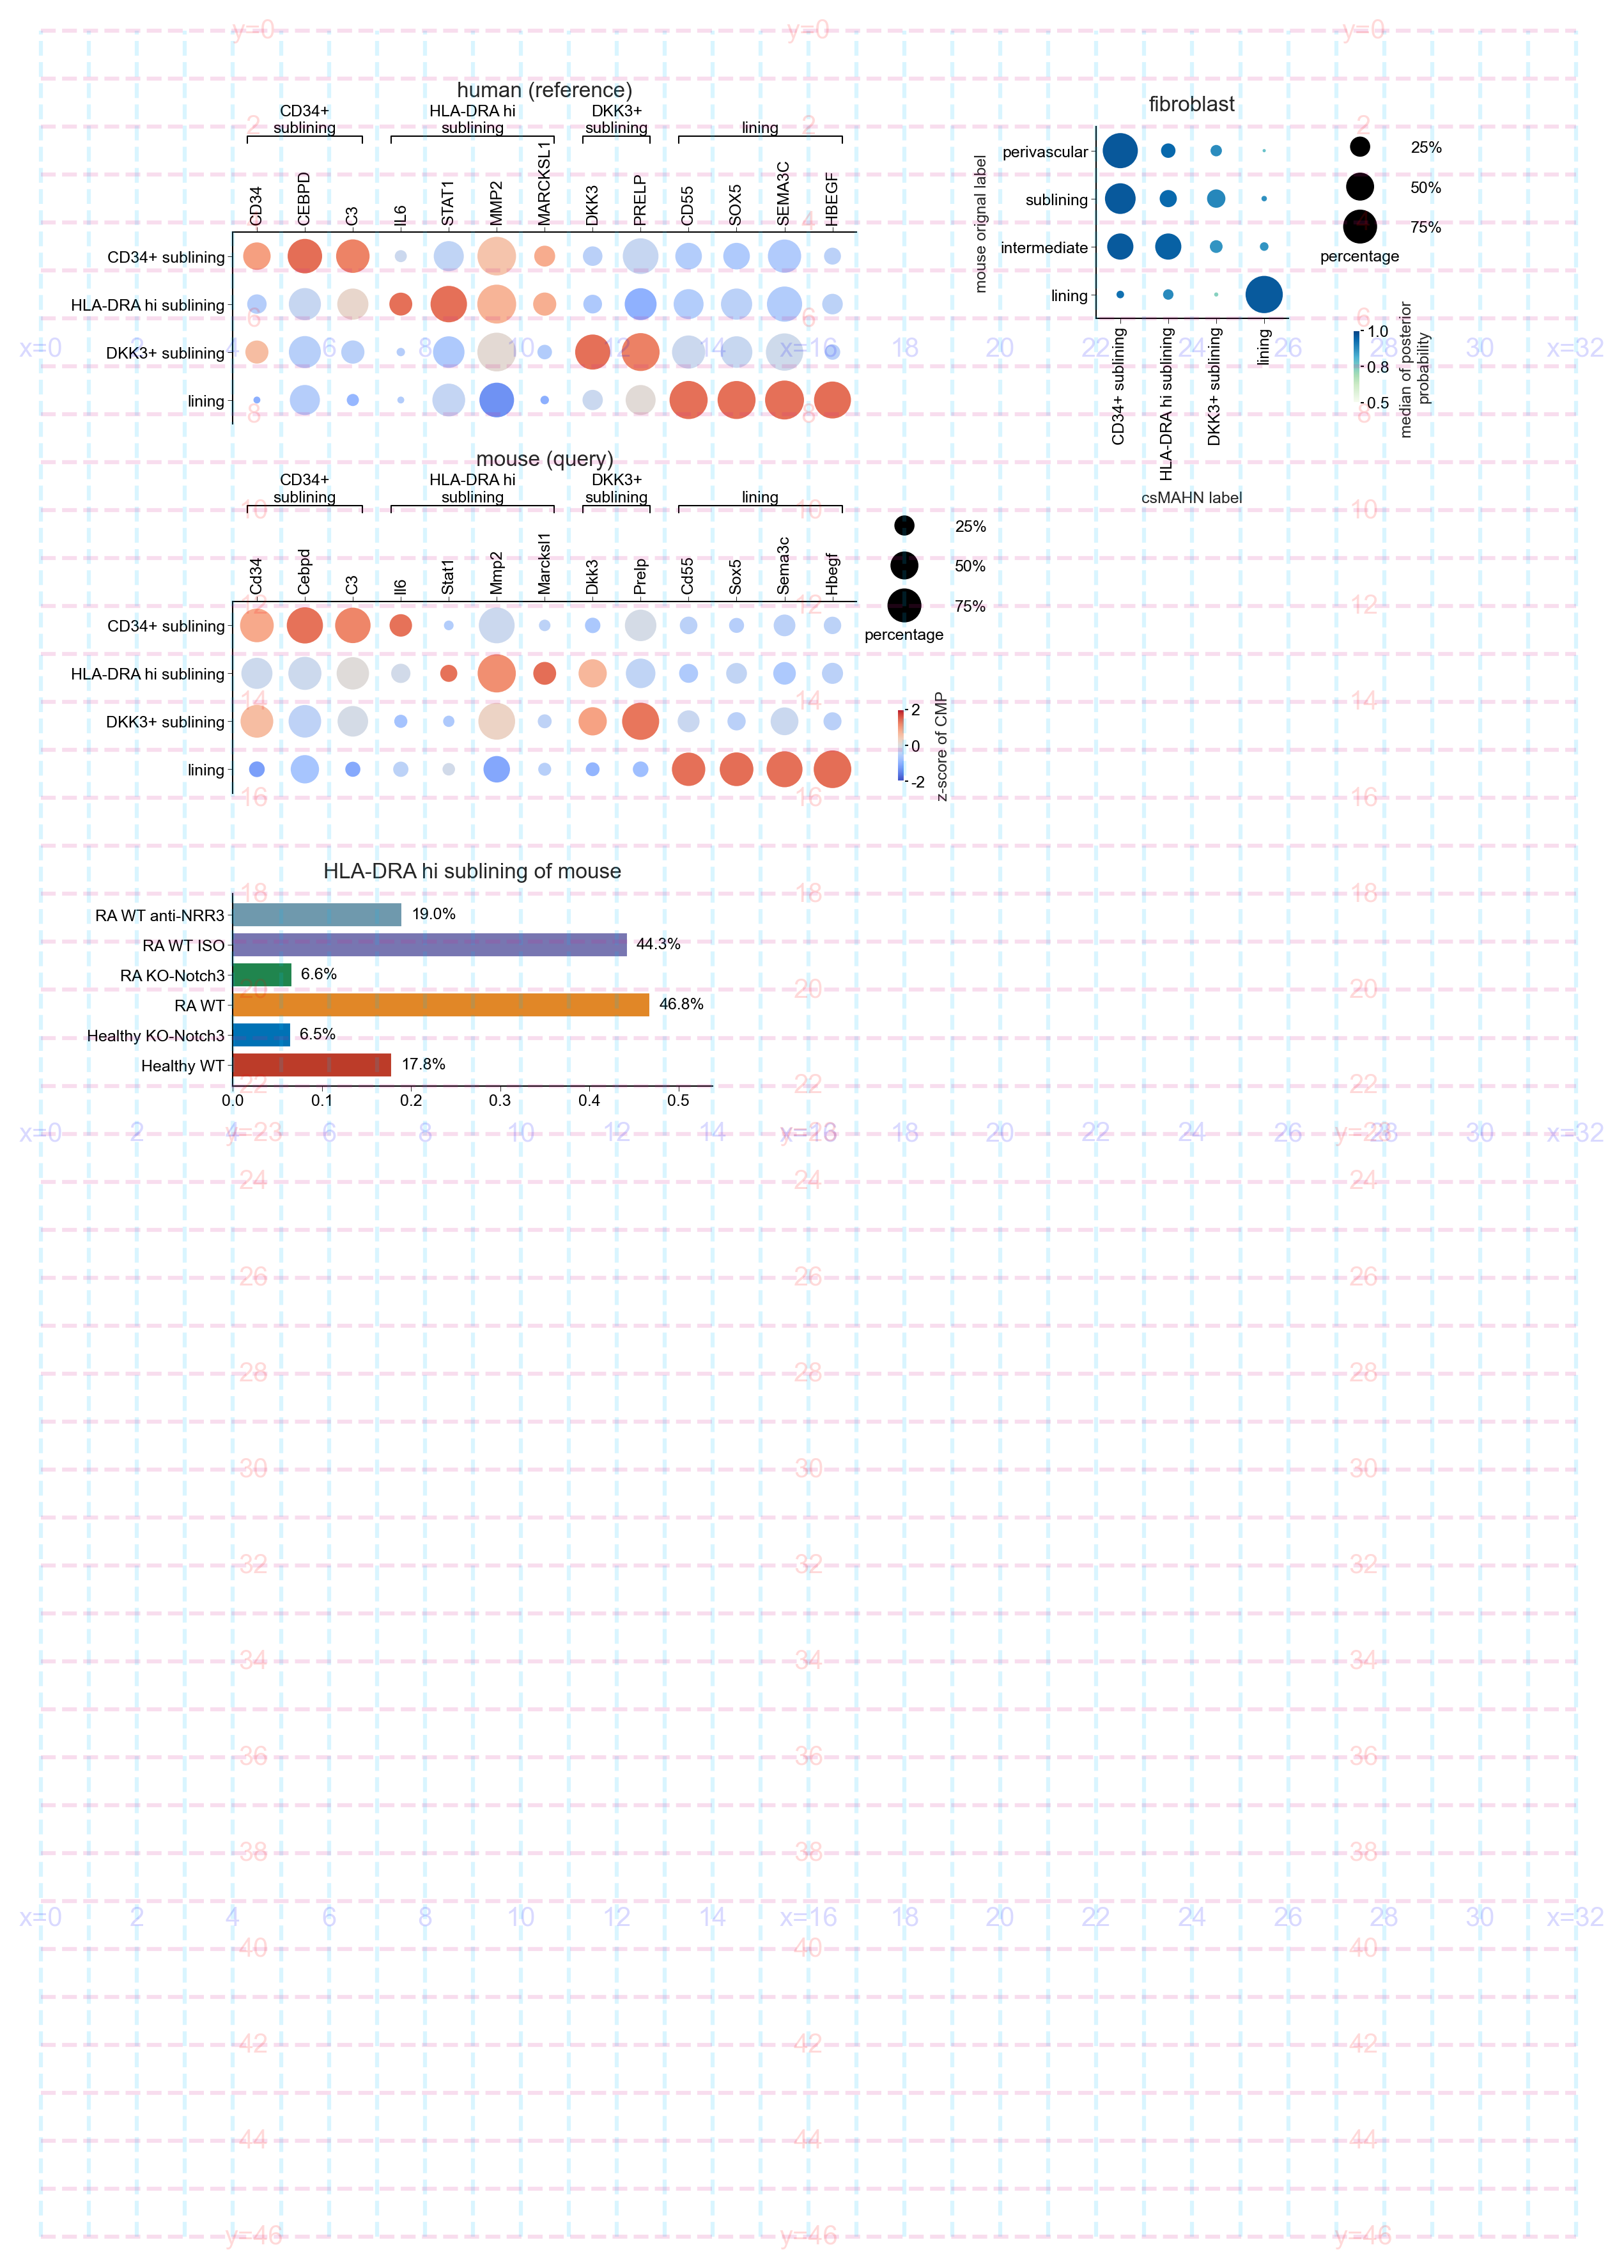

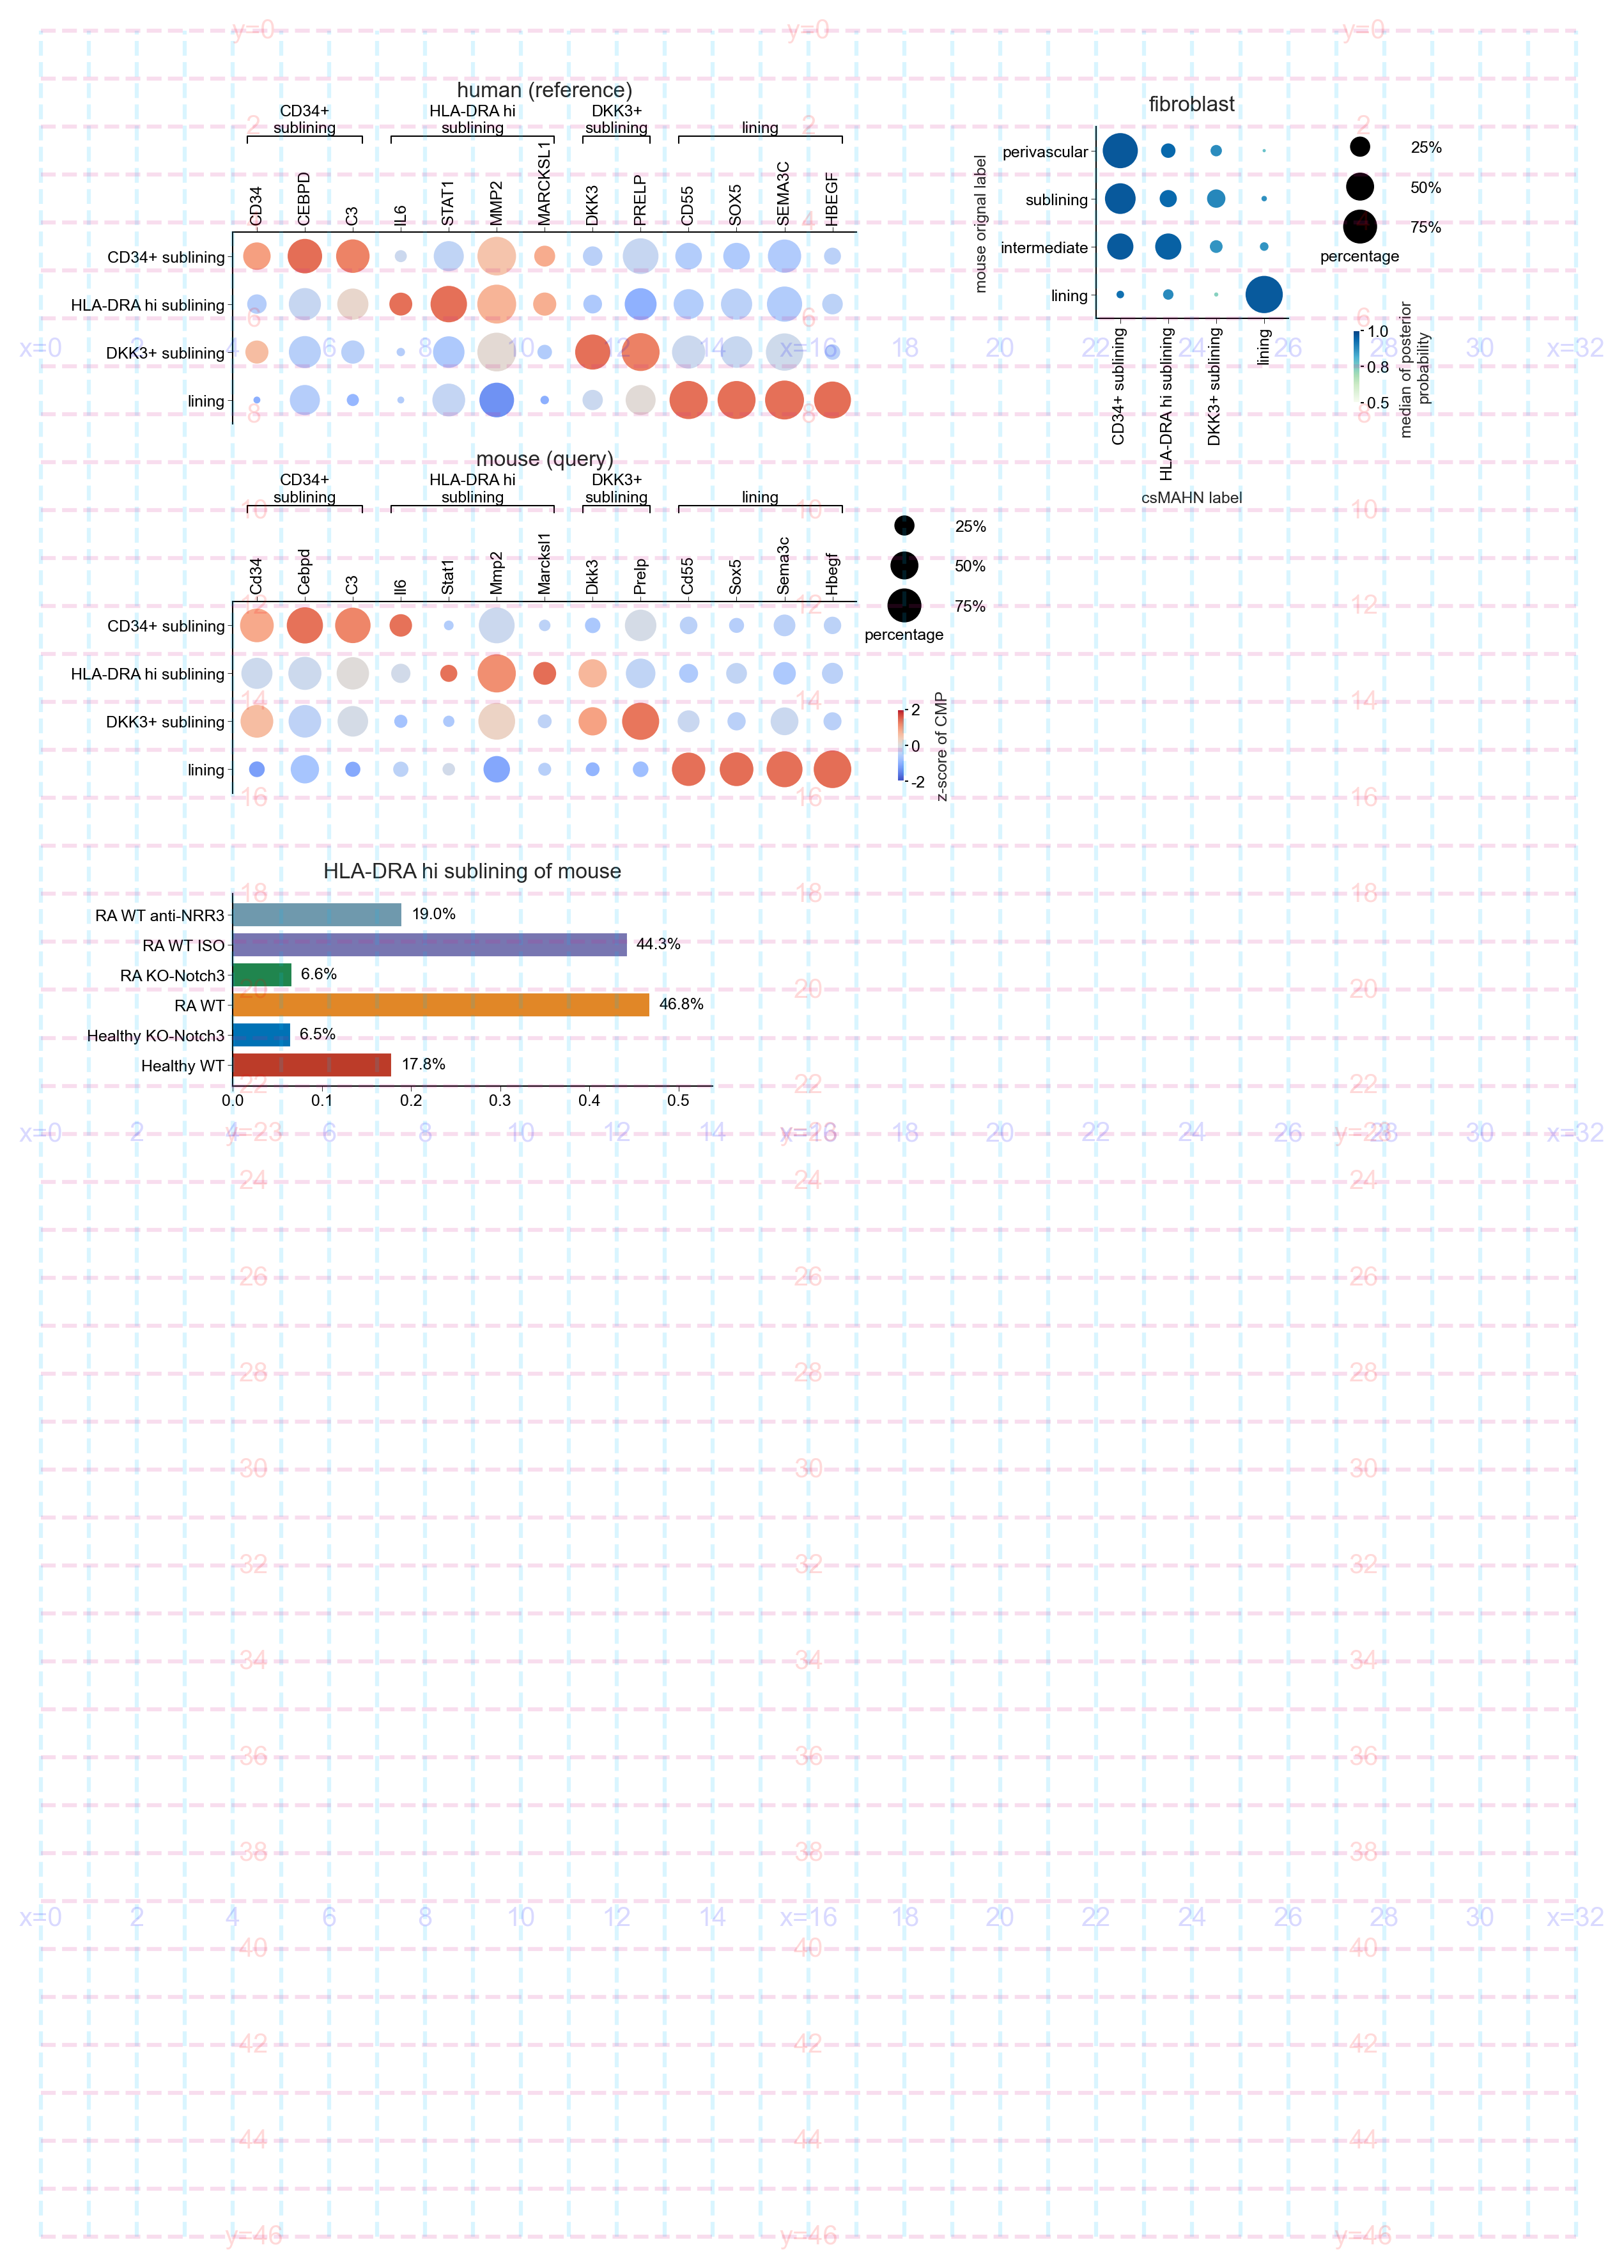

In [6]:
plt.close("all")
a4p = pl.figure.A4Page()
y = 2
with Block('marker', context=dict(x=4, y=y, item='csMAHN', size=1)) as context:
    row = ppara_data['res_RA'].loc[context.item, :]
    cmap = ppara_cmap['cell_type']
    adata = ppara_adata['hm_{}'.format(context.item)]
    marker_dict = ppara_data['marker_dotplot']
    adata_ref = load_normalized_adata(find_path_from_para(df_para,row['name_ref']),
                                     adata.obs)
    adata_que = load_normalized_adata(find_path_from_para(df_para,row['name_que']),
                                     adata.obs)
    kw_cbar=dict(format='{x:.0f}', aspect=10, label='z-score of CMP')
    ppara = dict(key_group='model_label',transpose = True,
                 kw_bubble=dict(vmax=2.5, vmin=-2.5, cmap='coolwarm'))

    with Block('ref'):
        ppara.update(adata=adata_ref,
                     genes=np.concatenate(list(marker_dict['ref'].values())),
                     order=list(marker_dict['ref'].keys()))
        with Block('bar'):
            ax = a4p.add_ax(context.x,context.y,len(ppara['genes']),1,rc=pl.rc_blank)
            ax.set_xlim(0,len(ppara['genes'])),ax.set_ylim(0,1)
            pl.tl_stats_bar(ax,[0+.3,3-.3],text='CD34+\nsublining',bottom=.65,top=.8)
            pl.tl_stats_bar(ax,[3+.3,7-.3],text='HLA-DRA hi\nsublining',bottom=.65,top=.8)
            pl.tl_stats_bar(ax,[7+.3,9-.3],text='DKK3+\nsublining',bottom=.65,top=.8)
            pl.tl_stats_bar(ax,[9+.3,13-.3],text='lining',bottom=.65,top=.8)
            ax.set_title('human (reference)',y=1.3)
        context.y += 2.2
        ax = a4p.add_ax(context.x,context.y,len(ppara['genes']),len(ppara['order']),rc=pl.rc_frame_lt)
        cbar = dotplot_marker(ax=ax, **ppara)
    context.y += 5.5
    with Block('que'):
        ppara.update(adata=adata_que,
                     genes=np.concatenate(list(marker_dict['que'].values())),
                     order=list(marker_dict['que'].keys()))
        with Block('bar'):
            ax = a4p.add_ax(context.x,context.y,len(ppara['genes']),1,rc=pl.rc_blank)
            ax.set_xlim(0,len(ppara['genes'])),ax.set_ylim(0,1)
            pl.tl_stats_bar(ax,[0+.3,3-.3],text='CD34+\nsublining',bottom=.65,top=.8)
            pl.tl_stats_bar(ax,[3+.3,7-.3],text='HLA-DRA hi\nsublining',bottom=.65,top=.8)
            pl.tl_stats_bar(ax,[7+.3,9-.3],text='DKK3+\nsublining',bottom=.65,top=.8)
            pl.tl_stats_bar(ax,[9+.3,13-.3],text='lining',bottom=.65,top=.8)
            ax.set_title('mouse (query)',y=1.3)
        context.y += 2.2
        ax = a4p.add_ax(context.x,context.y,len(ppara['genes']),len(ppara['order']),rc=pl.rc_frame_lt)
        cbar = dotplot_marker(ax=ax, **ppara)
    context.x += 13
    with Block('legend'):
        ax = a4p.add_ax(context.x,context.y-2, 2, 2.5, rc=update_dict(pl.rc_blank, {
            'ytick.labelright': True, 'xtick.labelbottom': True}))
        dotplot_marker_legend(ax,draw_cbar=False)

        ax = a4p.add_ax(context.x,context.y+2,1,2,rc=pl.rc_blank)
        cbar = a4p.fig.colorbar(cbar,ax=ax,**kw_cbar)
        cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    del row,cmap,adata,marker_dict,adata_ref,adata_que,kw_cbar,ppara

with Block('posterior probability', context=dict(x=22, y=y,
        cmap='GnBu',item='csMAHN',
        kw_cbar=dict(format='{x:.1f}', aspect=10,
        label='median of posterior \nprobability'))) as context:
    ppara = dict(
        data=ppara_adata['hm_{}'.format(context.item)].obs.query("dataset_type == 'que' "),
        kw_bubble=dict(vmax=1, vmin=.5, cmap=context.cmap),
        order_col=list(ppara_cmap['cell_type'].keys()),
        order_row= 'perivascular,sublining,intermediate,lining'.split(',')
    )
    ax = a4p.add_ax(context.x, context.y, len(ppara['order_col']),
                    len(ppara['order_row']),rc=pl.rc_frame)
    ax.set_title('fibroblast')
    cbar = dotplot_max_prob_median(ax=ax, **ppara)
    ax.set_ylabel('mouse orignal label')
    ax.set_xlabel('csMAHN label')
    

    ax = a4p.add_ax(context.x+4.5,context.y, 2, 2.5, rc=update_dict(pl.rc_blank,
            {'ytick.labelright': True, 'xtick.labelbottom': True}))
    dotplot_marker_legend(ax,draw_cbar=False)
    ax = a4p.add_ax(context.x+4.5, context.y+4, 1, 2, rc=pl.rc_blank)
    cbar = a4p.fig.colorbar(cbar, ax=ax, **context.kw_cbar)
    cbar.ax.tick_params('both', width=.5, length=1.5, color='black')
    del ppara, ax, cbar

y += 16
with Block('hbar',context=dict(ct= 'HLA-DRA hi sublining',x=4,y=y)) as context:
    with Block('data df_plot'):
        df_plot = ppara_data['m_statue_ct_csMAHN'].copy()
        data = df_plot.copy().rename(columns = {context.ct:'count'}).loc[:,['count']]
        data['total'] = df_plot.sum(axis=1)
        data['ratio'] = data.eval('count/total')
        # data['text'] = ut.df.apply_merge_field(data,'{count:.0f}/{total:.0f}')
        data['text'] = data['ratio'].apply(lambda x:'{:.1f}%'.format(x*100))
        data['y'] = np.arange(data.shape[0])
        df_plot = data.loc[:,['ratio']].transpose()

    ax = a4p.add_ax(context.x,context.y,10,4,rc=pl.rc_frame)
    cmap = ppara_cmap['m_status']
    para = dict(gap_between_group=2,width_one_bar=1,
               width_ratio=.8, to_horizontal=True)
    for i, (k) in enumerate(df_plot.columns):
        pl.bar(ax, df_plot, key_height=k,cmap=cmap,bottom=0,
               group_counts=df_plot.shape[0],ngroup=i,**para)
    ax.set_yticks(np.arange(len(data.index)),data.index)
    for i,row in data.iterrows():
        ax.text(row['ratio']+.01,row['y'],row['text'],pl.tl_fontdict('lc'))
    ax.set_xlim(0,data['ratio'].max()+.07)
    ax.set_title('{} of mouse'.format(context.ct))

    del df_plot,data,ax,cmap,para
a4p.add_grid()
a4p.fig

# finish

In [7]:
print('\n[finish]\n'.center(100, '-'))

---------------------------------------------
[finish]
---------------------------------------------
